# **АНАЛИЗ ПРОДАЖ ПЕКАРНИ**

Датасет содержит набор данных о продажах французской пекарни с 01.01.2021 по 30.09.2022

*Цель работы:* определить, существует ли в продажах сезонность по году, недели и времени суток

**Часть 1.** Импорт данных и всех необходимых библиотек. Очистка данных и подготовка к работе

In [951]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

In [952]:
df = pd.read_csv('/content/Bakery sales.csv')
df

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [953]:
df.drop(columns = ['Unnamed: 0'], axis = 1, inplace=True)
df
#в датасете есть столбец с порядковыми номерами без заголовка, который не отражает никакие нужные нам данные, поэтому удаляем его из таблицы. 

,date,time,ticket_number,article,Quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...
234000,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [954]:
df.info()
#Проверяем, нет ли пустых значений и избавляемся от них, а также форматов данных, которые потребуется изменить для удобства анализа

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


Пустых значений нет. Всего в датасете 234005 строк

Для дальнейшей работы нам понадобится:

**1.**   разделить столбец date отдельно на год, месяц и день

**2.**   cделать из данных в time новые категориальные переменные, чтобы проанализировать как время суток влияет на продажи

**3.**   изменить тип данных столбца unit_price из object в float, для того чтобы с ним можно было производить манипуляции

**4.**   cоздать новый столбец с общей суммой чека для дальнейшнего анализа

In [955]:
#1 изменим формат данных стоблца date, а также разделим на разные столбцы
df['date'] = df['date'].apply(lambda x: dt.date.fromisoformat(x))
df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

In [956]:
#добавим слобец с днем недели
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday

In [957]:
#2 Для начала посмотрим, какие уникальные значения есть в столбце time, чтобы понять время работы пекарни, от которого будем отталкиваться. 
#Cразу же просортируем их для удобства, и выведем только самое маленькое и самое большое значения
times = sorted(df['time'].unique())
[times[0], times[-1]]
#Понимаем, что пекарня работает с 7:00 до 20:00

['07:01', '20:01']

In [958]:
#С помощью функции создадим новые категории времени суток, которые пригодятся для анализа продаж
def get_time_cat(time_str): 
  time_arr = time_str.split(":")
  time = dt.time(int(time_arr[0]), int(time_arr[1]))
  if time <= dt.time(10, 59):
    return 'Утро'
  elif time <= dt.time(16, 59):
    return 'День'
  elif time >= dt.time(17, 00):
    return 'Вечер'

In [959]:
df['time_category'] = df['time'].apply(get_time_cat)

In [960]:
#3 Поменяем тип данных в unit_price. Для этого нужно также удалить знак евро и заменить запятые на точки, иначе тип данных не получится изменить
df['unit_price'] = df['unit_price'].str.replace('€','')
df['unit_price'] = df['unit_price'].str.replace(',','.')
df['unit_price'] = df['unit_price'].astype(float)

In [961]:
#4 Узнаем сумму чека. Сначала умножим количество одного артикула на стоимость за единицу
df['ticket_price'] = df['Quantity'] * df['unit_price']

In [962]:
df

,date,time,ticket_number,article,Quantity,unit_price,day,month,year,weekday,time_category,ticket_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90,2,1,2021,5,Утро,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2,1,2021,5,Утро,3.60
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2,1,2021,5,Утро,2.40
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15,2,1,2021,5,Утро,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2,1,2021,5,Утро,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...
234000,2022-09-30,18:52,288911.0,COUPE,1.0,0.15,30,9,2022,4,Вечер,0.15
234001,2022-09-30,18:52,288911.0,BOULE 200G,1.0,1.20,30,9,2022,4,Вечер,1.20
234002,2022-09-30,18:52,288911.0,COUPE,2.0,0.15,30,9,2022,4,Вечер,0.30
234003,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,30,9,2022,4,Вечер,1.30


**Часть 2.** Описательные статистики

In [963]:
df.describe()

,ticket_number,Quantity,unit_price,day,month,year,weekday,ticket_price
count,234005.000000,234005.000000,234005.000000,234005.000000,234005.000000,234005.000000,234005.000000,234005.000000
mean,219201.258738,1.538377,1.662195,16.014876,6.240862,2021.438388,3.341506,2.387303
std,40053.223896,1.289603,1.722720,8.763694,2.800774,0.496191,2.107319,2.635041
min,150040.000000,-200.000000,0.000000,1.000000,1.000000,2021.000000,0.000000,-200.000000
25%,184754.000000,1.000000,1.100000,9.000000,4.000000,2021.000000,1.000000,1.200000
50%,218807.000000,1.000000,1.200000,16.000000,7.000000,2021.000000,4.000000,1.600000
75%,253927.000000,2.000000,1.500000,24.000000,8.000000,2022.000000,5.000000,2.600000
max,288913.000000,200.000000,60.000000,31.000000,12.000000,2022.000000,6.000000,200.000000


In [964]:
df['Quantity'].unique()

array([   1.,    3.,    2.,    5.,    6.,    4.,   10.,   -1.,    8.,
          7.,   -4.,   -2.,   20.,    9.,   -3.,   -6.,   11.,   12.,
         -5.,   -9.,   13.,  -13.,  -12.,  -10.,  200., -200.,   15.,
         17.,   18.,   25.,   14.,  -17.,  -18.,   55.,   21.,   43.,
         16.,   -7.,   -8.,   50.])

В столбце quantity есть аномальные отрицательные значения, необходимо определить выбросы и избавиться от них


In [965]:
q1_Qua = df['Quantity'].quantile(0.25)
q3_Qua = df['Quantity'].quantile(0.75)
iqr_Qua = q3_Qua - q1_Qua
Qua_iqr_outlier_threshold_bottom = q1_Qua - 1.5 * iqr_Qua
Qua_iqr_outlier_threshold_up = q3_Qua + 1.5 * iqr_Qua
Qua_iqr_outlier_threshold_bottom
Qua_iqr_outlier_threshold_up

3.5

In [966]:
df = df[df['Quantity'] > 0]
df = df[df['Quantity'] < 3.5]

In [967]:
df_price_total = df.groupby('ticket_number').agg({
    'day': 'first',
    'month': 'first',
    'year': 'first',
    'weekday': 'first',
    'time_category': 'first',
    'Quantity': 'sum',
    'ticket_price': 'sum',
    'article': lambda x: list(x)
})
df_price_total

,day,month,year,weekday,time_category,Quantity,ticket_price,article
ticket_number,,,,,,,,
150040.0,2,1,2021,5,Утро,4.0,4.50,"[BAGUETTE, PAIN AU CHOCOLAT]"
150041.0,2,1,2021,5,Утро,3.0,3.55,"[PAIN AU CHOCOLAT, PAIN]"
150043.0,2,1,2021,5,Утро,5.0,5.10,"[BAGUETTE, CROISSANT]"
150044.0,2,1,2021,5,Утро,1.0,1.05,[BANETTE]
150045.0,2,1,2021,5,Утро,3.0,3.60,[TRADITIONAL BAGUETTE]
...,...,...,...,...,...,...,...,...
288908.0,30,9,2022,4,Вечер,2.0,2.70,[CEREAL BAGUETTE]
288910.0,30,9,2022,4,Вечер,1.0,1.30,[TRADITIONAL BAGUETTE]
288911.0,30,9,2022,4,Вечер,6.0,5.65,"[CAMPAGNE, COUPE, BOULE 200G, COUPE]"


**Корреляция**

Посмотрим, существует ли зависимость между днем/месяцем и количеством продукции

In [968]:
df_price_total['Quantity'].corr(df_price_total['month']) 
#0,02 - зависимости между количеством товара в чеке и месяцем нет

0.019445381784248855

In [969]:
df_price_total['Quantity'].corr(df_price_total['day'])
#0,007 - зависимости между количеством товара в чеке и числом месяца нет

0.006918068856966193

Каких-либо значимых корреляций в датасете не обнаружено

**Часть 3.** Визуализация данных

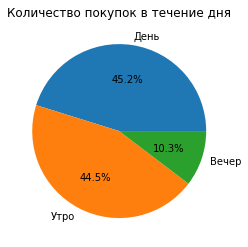

In [970]:
df_price_total['time_category'].value_counts().plot(kind='pie', autopct='%1.1f%%', title = 'Количество покупок в течение дня')
plt.ylabel('')
plt.show()

Подавляющее большинство покупок, совершенных в пекарне, приходятся на утро или день, и лишь 10% покупают что-либо вечером

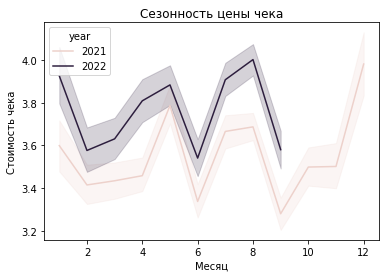

In [971]:
sns.lineplot(data=df_price_total, x="month", y="ticket_price", hue="year")
plt.title('Сезонность цены чека')
plt.xlabel('Месяц')
plt.ylabel('Стоимость чека')
plt.show()

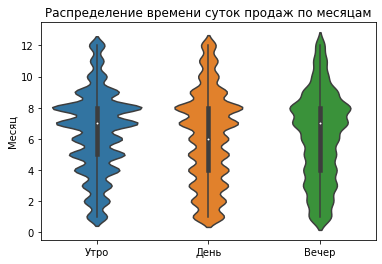

In [972]:
sns.violinplot(x = df_price_total['time_category'], y = df_price_total['month'])
plt.xlabel('')
plt.ylabel('Месяц')
plt.title('Распределение времени суток продаж по месяцам')
plt.show()

Из двух визуализаций можно сделать вывод, что больше всего продаж в пекарне совершается летом (с пиком в августе)

**Часть 4.** Тестирование гипотез

H0: в рабочие дни продажи вечером будут выше, чем в выходные

Для начала необходимо ввести новую переменную, которая указывала бы на рабочий день недели (1) или выходной (0). Для этого воспользуемся функцией условия

In [973]:
def get_weekday_cat(weekday): 
    if weekday <=4:
        return '1'
    else:
        return '0'
df_price_total['day_type']=df_price_total['weekday'].apply(get_weekday_cat)
df_price_total['day_type'] = df_price_total['day_type'].astype(int)

In [974]:
df_price_total.head()

,day,month,year,weekday,time_category,Quantity,ticket_price,article,day_type
ticket_number,,,,,,,,,
150040.0,2,1,2021,5,Утро,4.0,4.50,"[BAGUETTE, PAIN AU CHOCOLAT]",0
150041.0,2,1,2021,5,Утро,3.0,3.55,"[PAIN AU CHOCOLAT, PAIN]",0
150043.0,2,1,2021,5,Утро,5.0,5.10,"[BAGUETTE, CROISSANT]",0
150044.0,2,1,2021,5,Утро,1.0,1.05,[BANETTE],0
150045.0,2,1,2021,5,Утро,3.0,3.60,[TRADITIONAL BAGUETTE],0


In [975]:
ct_o = df_price_total.groupby ('day_type')['time_category'].value_counts().unstack()
ct_o

time_category,Вечер,День,Утро
day_type,,,
0,2182,19923,23030
1,11314,39068,35059


In [976]:
alpha = 0.01
dof = (2-1) * (3-1)
dof

2

In [977]:
#при степени свободы 2 и критической точке распределения 0,01 получаем критическое значение из таблицы Пирсона:
critical_value = 9,21

In [978]:
scipy.stats.chi2_contingency(ct_o, correction = False)

(2698.9813407771626,
 0.0,
 2,
 array([[ 4665.03767921, 20390.87416524, 20079.08815556],
        [ 8830.96232079, 38600.12583476, 38009.91184444]]))

**Вывод:** Значение 2 говорит о том, что зависимость между покупкой вечером в будни и в выходные есть

**Часть 5.** Линейная регрессия 

In [979]:
df_price_total.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 130576 entries, 150040.0 to 288913.0
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            130576 non-null  int64  
 1   month          130576 non-null  int64  
 2   year           130576 non-null  int64  
 3   weekday        130576 non-null  int64  
 4   time_category  130576 non-null  object 
 5   Quantity       130576 non-null  float64
 6   ticket_price   130576 non-null  float64
 7   article        130576 non-null  object 
 8   day_type       130576 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 14.0+ MB


In [980]:
quantity_mean = df_price_total.groupby(df_price_total['day'])['Quantity'].mean()
ticket_price_sum = df_price_total.groupby(df_price_total['day'])['ticket_price'].sum()
unit_price_mean = df.groupby(df['day'])['unit_price'].mean()

lin_data = pd.concat([quantity_mean,ticket_price_sum, unit_price_mean], axis = 1)
lin_data.head()

,Quantity,ticket_price,unit_price
day,,,
1,2.270563,13536.40,1.673616
2,2.229142,15414.45,1.713645
3,2.264049,15043.83,1.707015
4,2.204616,14917.45,1.677594
5,2.269513,16053.10,1.694674


Делаем проверку данных с помощью графиков распределения и карты корреляций

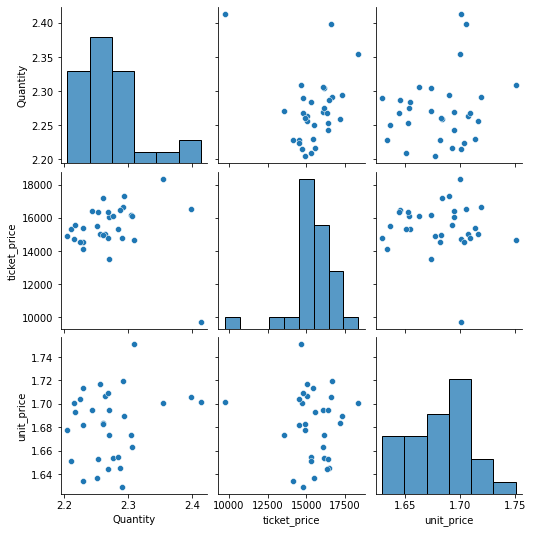

In [981]:
sns.pairplot(lin_data)
plt.show()

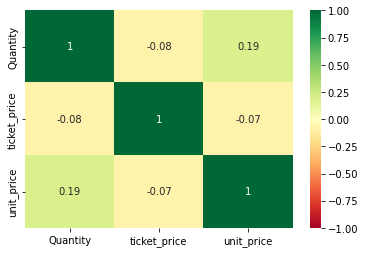

In [982]:
plt.figure()
sns.heatmap(lin_data.corr(), annot = True, cmap='RdYlGn', vmax = 1, vmin = -1)

In [983]:
X = lin_data['unit_price']
y = lin_data['Quantity']

res = scipy.stats.linregress(X, y)
res

LinregressResult(slope=0.32221233895705886, intercept=1.7299479202129016, rvalue=0.1934653309618788, pvalue=0.2970424080393847, stderr=0.3034285501317468, intercept_stderr=0.5104088468593092)

In [984]:
r_sq = res.rvalue ** 2
r_sq
#коэффициент детерминации = 0,04, таким образом мы видим, что переменные практически не взаимосвязаны друг с другом

0.0374288342841893

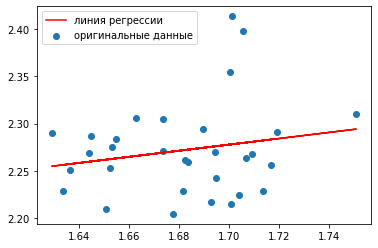

In [985]:
plt.scatter(X, y, label = 'оригинальные данные')
plt.plot(X, res.intercept + res.slope * X, 'r', label = 'линия регрессии')
plt.legend()
plt.show()

**Вывод:** Таким образом, линейная регрессия показала, что цена на единицу товара не влияет на общее количество товаров в чеке